### Домашнее задание 3 «Модели ARMA»

### Задание

1. Выберите ряд из первого задания.  
2. Постройте его модель ARIMA.  
3. Оформите отчёт в Jupyter-ноутбук.  
Дополнительное задание*  
Попробуйте спрогнозировать график классическим ML.  

In [4]:
import pandas as pd
import numpy as np
import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa import arima
from statsmodels.tsa.ar_model import ar_select_order

from arch.univariate import arch_model

from scipy.stats import boxcox
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline

In [288]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [289]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

1. Выберите ряд из первого задания.  

**Ряд "Monthly sales of company X"**

In [277]:
series = pd.read_csv('D:\\Git_repos\\time_series\\data\\Series\\monthly-sales-of-company-x-jan-6.csv')['Count']

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


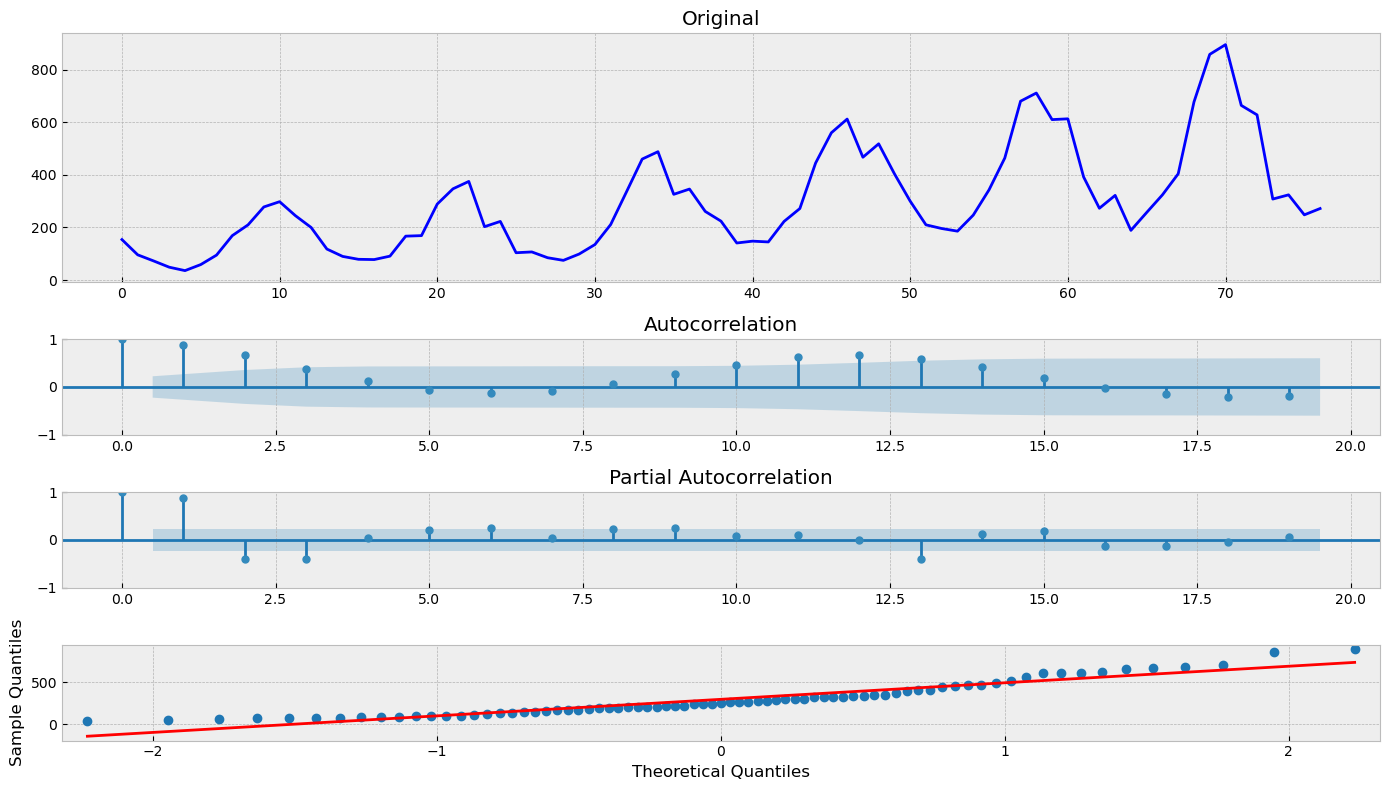

In [284]:
tsplot(series)

## Модель ARIMA (p,d,q)

Подбираем параметры для минимального показателя aic.

In [278]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                
                tmp_mdl = smt.arima.ARIMA(series, order=(i,d,j), trend='n').fit()
                
                tmp_aic = tmp_mdl.aic
                
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue

D:\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting M

In [279]:
print(f'aic: {best_aic:6.5f} | order: {best_order}')

aic: 854.01897 | order: (4, 2, 3)


Results of Dickey-Fuller Test:
Test Statistic                 -1.913366
p-value                         0.325800
#Lags Used                     11.000000
Number of Observations Used    65.000000
Critical Value (1%)            -3.535217
Critical Value (5%)            -2.907154
Critical Value (10%)           -2.591103
dtype: float64


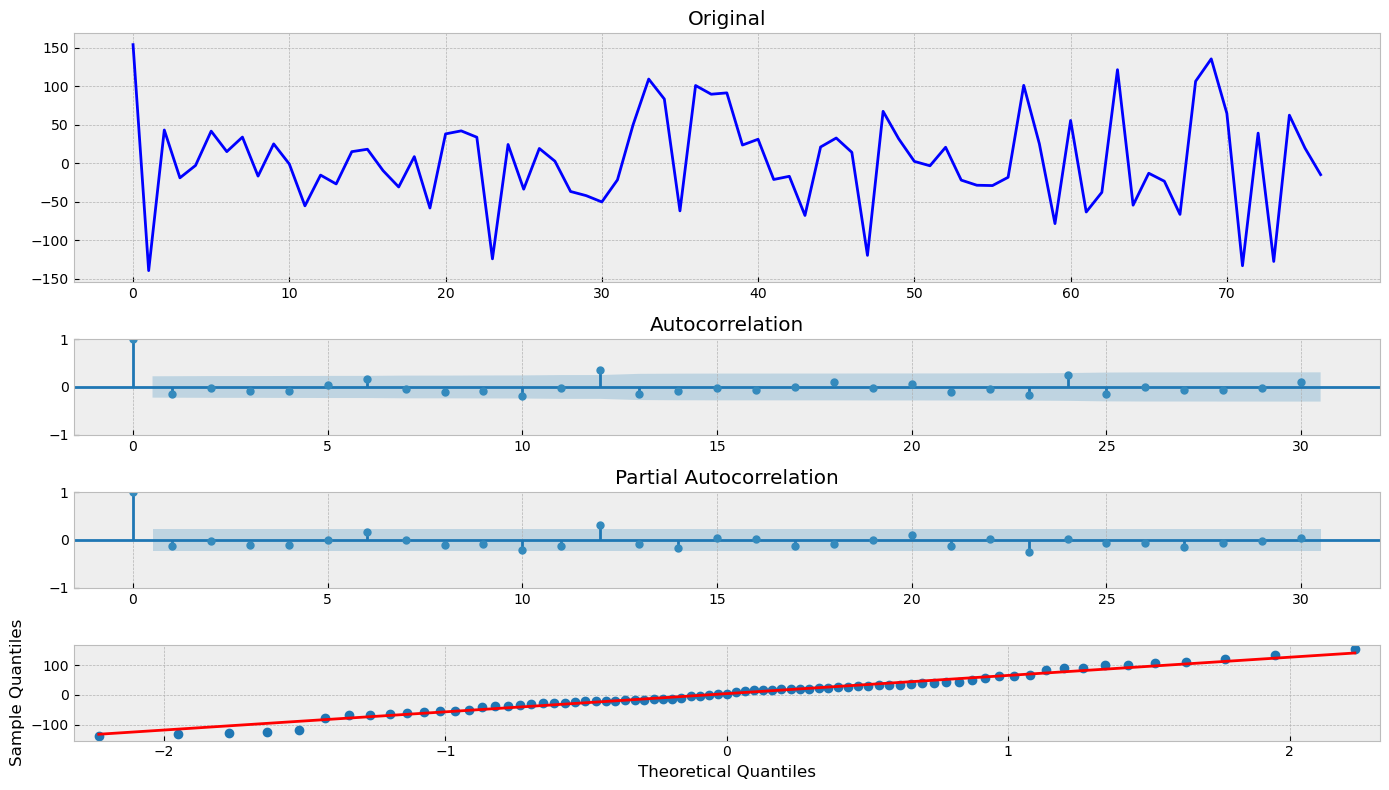

In [280]:
tsplot(best_mdl.resid, lags=30)

In [281]:
best_mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Count   No. Observations:                   77
Model:                 ARIMA(4, 2, 3)   Log Likelihood                -419.009
Date:                Tue, 05 Dec 2023   AIC                            854.019
Time:                        14:35:14   BIC                            872.559
Sample:                             0   HQIC                           861.422
                                 - 77                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3053      0.116     11.300      0.000       1.079       1.532
ar.L2         -0.3102      0.179     -1.738      0.082      -0.660       0.040
ar.L3         -0.3635      0.165     -2.201      0.028      -0.687      -0.040
ar.L4         -0.0316      0.104     -0.303      0.762      -0.236       0.172
ma.L1         -2.9005      0.184    -15.757      0.000      -3.261      -2.540
ma.L2          2.8981      0.359      8.065      0.000       2.194       3.602
ma.L3         -0.9974      0.182     -5.478      0.000      -1.354      -0.641
sigma2      3103.0623      0.000   9.16e+06      0.000    3103.062    3103.063
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):                 0.21
Prob(Q):                              0.62   Prob(JB):                         0.90
Heteroskedasticity (H):               4.58   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.8e+22. Standard errors may be unstable.
"""

Предсказание на 10 лагов.

In [282]:
pred = best_mdl.predict(start=1, end=len(series)+10)

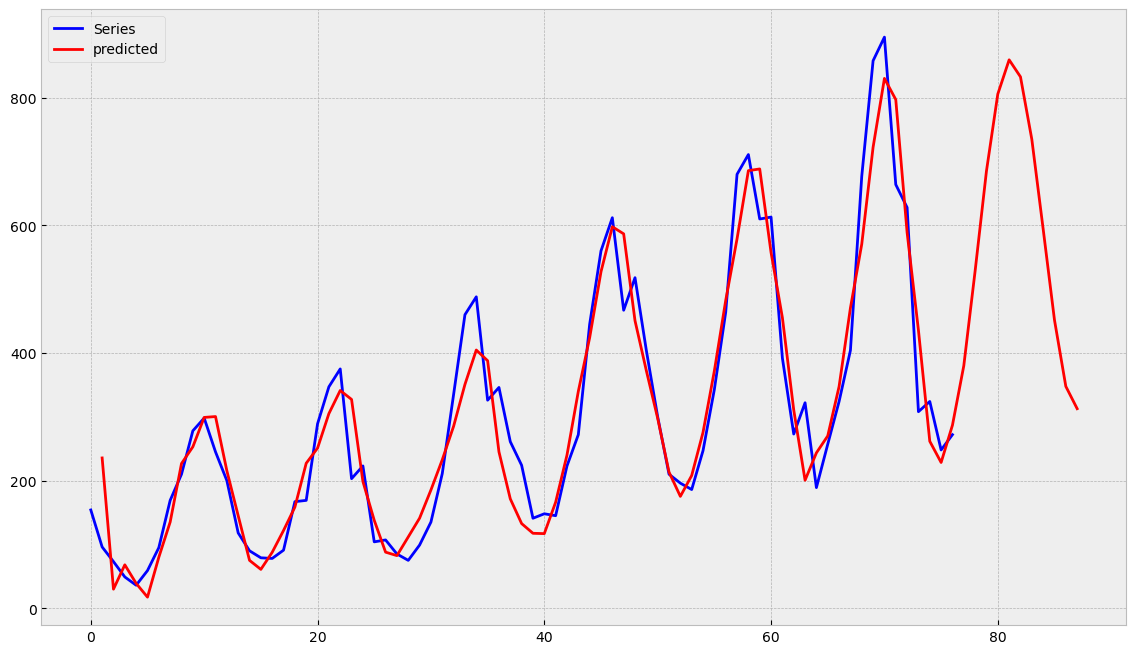

In [283]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()

    plt.plot(series, color='blue', label='Series')
    plt.plot(pred, color='red', label='predicted')
    plt.legend()
    plt.show()

## Прогнозирование с помощью модели линейной регрессии LinearRegression

In [5]:
# "Monthly sales of company X"
series = pd.read_csv('D:\\Git_repos\\time_series\\data\\Series\\monthly-sales-of-company-x-jan-6.csv') 

In [8]:
series.head(3)

,Month,Count
0,1965-01,154
1,1965-02,96
2,1965-03,73


In [9]:
def prepareData(data, lag_start, lag_end, test_size):
    """
    Формирует датафрейм признаков для прогнозирования временнного ряда с помощью LinearRegression.
    data - pandas.core.frame.DataFrame, содержащий исходный временной ряд, 
            где в первой колонке данные времени, во второй - значения ряда 
    lag_start - int., начало окна сканирования, 
    lag_end - int., окончанипе окна, 
    test_size - 0...1, размер тестовых данных, как доля длины ряда
    """
    
    data = pd.DataFrame(data.copy())
        
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data[f"lag_{i}"] = data.Count.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(data.columns[[0]], axis=1)
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
         
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(data.columns[0], axis=1)
    y_train = data.loc[:test_index][data.columns[0]]
    X_test = data.loc[test_index:].drop(data.columns[0], axis=1)
    y_test = data.loc[test_index:][data.columns[0]]
    
    return X_train, X_test, y_train, y_test

In [14]:
X_train, X_test, y_train, y_test = prepareData(series, lag_start=1, lag_end=10, test_size=0.4)

In [15]:
X_train.shape, X_test.shape

((41, 9), (28, 9))

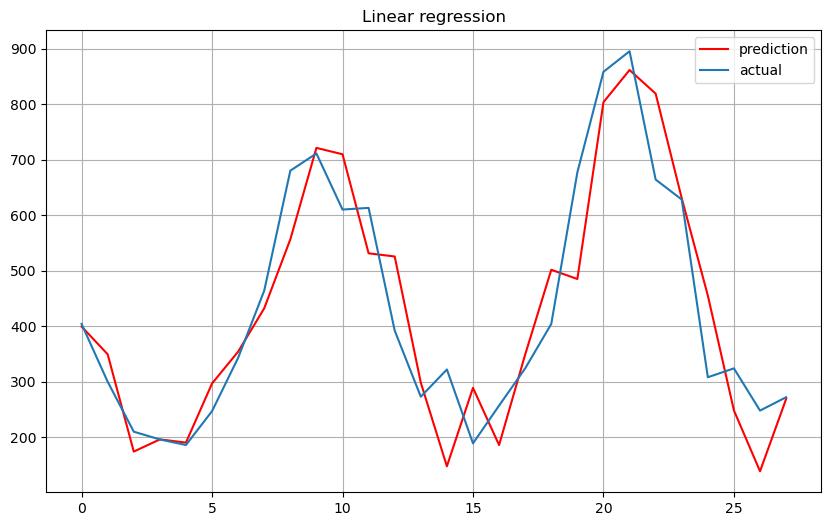

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

In [17]:
lr.score(X_test, y_test)

0.8195079726351606